In [1]:
import sys
sys.path.append("C:/Users/Nikhil/OneDrive - Southern Methodist University/Education/MOOC/fastai") # go to parent dir

In [2]:
import fastai; 
from fastai import *

In [3]:
fastai.__version__

'1.0.58'

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader  # lets us load data in batches

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
%matplotlib inline

In [5]:
# Reading data 
df = pd.read_csv("../../SMU_DS7331_Promotions_final/data/data_for_classification.csv")

## 1. Data Cleanup

**This is the same preprocesing that was done in Lab2 for SMU - DS7331 (Machine Learning 1 class). Please refer to that notebook for detailed explanation of what is being done.**

### 1.1 Remove Null Values

In [6]:
null_vals = df.isnull().sum(axis = 0)
print(null_vals[null_vals != 0])
df.dropna(inplace=True)

reporting_level_last                 14
accountability_matrix_label_last      3
functional_area_last                  3
job_family_label_last                 5
job_long_text_last                    6
operational_rollup_label_last       191
org_unit_desc_last                   44
dtype: int64


### 1.2 Remvove categorical variables with large number of levels 
**May reconsider later if using enbeddings in the NN**

In [7]:
categorical_features = df.select_dtypes(include='object').columns
categorical_features

Index(['worker', 'accountability_matrix_label_last', 'company_code_last',
       'cost_center_code_last', 'functional_area_last', 'supervisor_last',
       'gjs_code_label_last', 'gjs_framework_last', 'job_family_label_last',
       'job_long_text_last', 'operational_rollup_label_last',
       'org_unit_desc_last', 'site_city_code_last', 'site_country_code_last',
       'site_country_region_last', 'site_country_segment_last',
       'site_desc_last', 'certificate_order_grp_last'],
      dtype='object')

In [8]:
for column in categorical_features:
    if column in df.columns:
        print ("The number of levels in column '{}': {}".format(column,df[column].nunique()))

The number of levels in column 'worker': 66927
The number of levels in column 'accountability_matrix_label_last': 29
The number of levels in column 'company_code_last': 50
The number of levels in column 'cost_center_code_last': 1943
The number of levels in column 'functional_area_last': 3
The number of levels in column 'supervisor_last': 9755
The number of levels in column 'gjs_code_label_last': 43
The number of levels in column 'gjs_framework_last': 9
The number of levels in column 'job_family_label_last': 199
The number of levels in column 'job_long_text_last': 1506
The number of levels in column 'operational_rollup_label_last': 162
The number of levels in column 'org_unit_desc_last': 8342
The number of levels in column 'site_city_code_last': 224
The number of levels in column 'site_country_code_last': 28
The number of levels in column 'site_country_region_last': 3
The number of levels in column 'site_country_segment_last': 11
The number of levels in column 'site_desc_last': 318
The 

In [9]:
cols_to_del = ["supervisor_last"
               ,"org_unit_desc_last"
               ,"cost_center_code_last"
               ,"job_long_text_last"
               ,"site_city_code_last"
               ,"site_desc_last"  
               ,"year_last"
               ,"month_num_last"
               ,'months_since_promotion_max'
               ,"worker"
               ,"Unnamed: 0"
                ]
for column in df.columns:
    if column in cols_to_del:
        del df[column]

In [10]:
categorical_features = df.select_dtypes(include='object').columns
for column in categorical_features:
    if column in df.columns:
        print ("The number of levels in column '{}': {}".format(column,df[column].nunique()))

The number of levels in column 'accountability_matrix_label_last': 29
The number of levels in column 'company_code_last': 50
The number of levels in column 'functional_area_last': 3
The number of levels in column 'gjs_code_label_last': 43
The number of levels in column 'gjs_framework_last': 9
The number of levels in column 'job_family_label_last': 199
The number of levels in column 'operational_rollup_label_last': 162
The number of levels in column 'site_country_code_last': 28
The number of levels in column 'site_country_region_last': 3
The number of levels in column 'site_country_segment_last': 11
The number of levels in column 'certificate_order_grp_last': 14


In [11]:
# df.info()

## 2. Modeling

In [15]:
from fastai.tabular import * 

### 2.1 Define the Data Object

In [16]:
procs = [FillMissing, Categorify, Normalize]

In [17]:
valid_idx = range(len(df)-int(0.2*len(df)), len(df))
valid_idx

range(75287, 94108)

In [18]:
#categorical_features.values

In [19]:
dep_var = 'promotion_max'
cat_names = list(categorical_features.values)

In [20]:
data = TabularDataBunch.from_df(".", df, dep_var, valid_idx=valid_idx, procs=procs, cat_names=cat_names)
print(data.train_ds.cont_names)  # `cont_names` defaults to: set(df)-set(cat_names)-{dep_var}

['hiredAfter200901_max', 'supervisor_Y_max', 'reporting_level_last', 'mgr_08_nunique', 'site_country_code_nunique', 'mgr_02_nunique', 'cost_center_code_nunique', 'mgr_06_nunique', 'site_country_segment_nunique', 'mgr_05_nunique', 'mgr_11_nunique', 'site_country_region_nunique', 'supervisor_nunique', 'operational_rollup_label_nunique', 'tenure_in_months_last', 'company_code_nunique', 'mgr_01_nunique', 'awards_peer_cnt_sum_last', 'awards_bonus_cnt_sum_last', 'org_unit_desc_nunique', 'promotion_cnt', 'span_of_control_direct_last', 'span_of_control_total_last', 'movement_demote_event_cnt_sum_last', 'school_tier_last', 'mgr_12_nunique', 'mgr_03_nunique', 'supervisor_Y_last', 'mgr_04_nunique', 'transfer_event_cnt_sum_last', 'awards_bonus_sum_last', 'mgr_07_nunique', 'mgr_09_nunique', 'gjs_code_label_nunique', 'functional_area_nunique', 'awards_points_sum_last', 'job_long_text_nunique', 'gjs_sort_order_last', 'accountability_matrix_label_nunique', 'comparatio_last', 'gjs_framework_nunique', '

### 2.2 Compute Embedding Size

In [21]:
for cat in cat_names:
    df[cat] = df[cat].astype('category')

cat_szs = [len(df[col].cat.categories) for col in cat_names]
emb_szs = [min(50, (size+1)//2) for size in cat_szs]
emb_szs

[15, 25, 2, 22, 5, 50, 50, 14, 2, 6, 7]

In [22]:
emb_szs_fastai = {name: value for (name, value) in zip(cat_names,emb_szs)}
emb_szs_fastai

{'accountability_matrix_label_last': 15,
 'company_code_last': 25,
 'functional_area_last': 2,
 'gjs_code_label_last': 22,
 'gjs_framework_last': 5,
 'job_family_label_last': 50,
 'operational_rollup_label_last': 50,
 'site_country_code_last': 14,
 'site_country_region_last': 2,
 'site_country_segment_last': 6,
 'certificate_order_grp_last': 7}

### 2.3 Define Learner

In [23]:
learn = tabular_learner(data, layers=[200,100,50], emb_szs=emb_szs_fastai, metrics=accuracy)
learn.summary()

TabularModel
Layer (type)         Output Shape         Param #    Trainable 
Embedding            [15]                 450        True      
______________________________________________________________________
Embedding            [25]                 1,275      True      
______________________________________________________________________
Embedding            [2]                  8          True      
______________________________________________________________________
Embedding            [22]                 968        True      
______________________________________________________________________
Embedding            [5]                  50         True      
______________________________________________________________________
Embedding            [50]                 9,900      True      
______________________________________________________________________
Embedding            [50]                 8,100      True      
_________________________________________________

### 2.4 Train the model

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


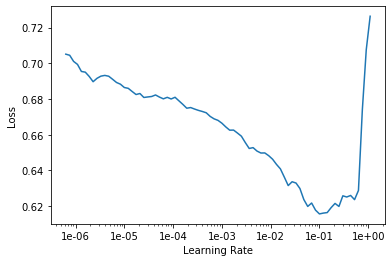

In [24]:
learn.lr_find()
learn.recorder.plot()

In [25]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.396649,0.486496,0.773019,01:50
1,0.351621,0.458388,0.803571,01:49
2,0.336152,0.439945,0.786462,01:48
3,0.317493,0.384181,0.820998,01:51
4,0.279094,0.386155,0.823548,01:47


## 3. Evaluations

### 3.1 Predictions

In [26]:
learn.predict(df.iloc[valid_idx[0]]) # Does not work on more than 1 example, not sure why

(Category 0, tensor(0), tensor([0.7320, 0.2680]))

In [27]:
preds = learn.get_preds()

In [28]:
print(preds[0].shape) # This is the validation set
print(preds[1].shape) # Actual Label

torch.Size([18821, 2])
torch.Size([18821])


### 3.2 Metrics

In [29]:
from sklearn.metrics import confusion_matrix
y_true = preds[1]
y_pred = preds[0].argmax(dim=1)
confusion_matrix(y_true, y_pred)

array([[13216,  2615],
       [  706,  2284]], dtype=int64)

In [30]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.83      0.89     15831
           1       0.47      0.76      0.58      2990

    accuracy                           0.82     18821
   macro avg       0.71      0.80      0.73     18821
weighted avg       0.87      0.82      0.84     18821



## 4. TODO / Followups

* How to use a balanced dataset with fast.ai
* How to use custom metrics with fast.ai
* How to plot validation and train loss (similar to this: https://github.com/adriangrepo/my_fastai/blob/master/dl2/translate.ipynb)
* Lern how to use learn.predict with DataLoader instead of the Dataframe directly